In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torch.optim import AdamW


In [ ]:
df = pd.read_csv('Yorubanumbers1-6000.csv')


In [ ]:
df.head(20)

,Number,Roman_Numeral,Yoruba
0,1,I,Okan
1,2,II,Meji
2,3,III,Meta
3,4,IV,Merin
4,5,V,Aarun
5,6,VI,Mefa
6,7,VII,Meje
7,8,VIII,Mejo
8,9,IX,Mesan
9,10,X,Eewa


In [ ]:
df.tail(20)

,Number,Roman_Numeral,Yoruba
5982,5981,V̅CMLXXXI,Ẹdẹgbata ati Okanlelogorun ladégbẹrun
5983,5982,V̅CMLXXXII,Ẹdẹgbata ati Mejilelogorun ladégbẹrun
5984,5983,V̅CMLXXXIII,Ẹdẹgbata ati Mẹtalelogorun ladégbẹrun
5985,5984,V̅CMLXXXIV,Ẹdẹgbata ati Mẹrinlelogorun ladégbẹrun
5986,5985,V̅CMLXXXV,Ẹdẹgbata ati Marunlelogorun ladégbẹrun
5987,5986,V̅CMLXXXVI,Ẹdẹgbata ati Mẹfalelogorun ladégbẹrun
5988,5987,V̅CMLXXXVII,Ẹdẹgbata ati Mejelelogorun ladégbẹrun
5989,5988,V̅CMLXXXVIII,Ẹdẹgbata ati Mẹjọlelogorun ladégbẹrun
5990,5989,V̅CMLXXXIX,Ẹdẹgbata ati Mẹsanlelogorun ladégbẹrun
5991,5990,V̅CMXC,Ẹdẹgbata ati Aadọrun ladégbẹrun


In [ ]:
from transformers import MT5Tokenizer, MT5ForConditionalGeneration

tokenizer = MT5Tokenizer.from_pretrained("google/mt5-xl", legacy=False)
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-xl")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


In [ ]:
import pandas as pd
df['Input'] = df['Roman_Numeral']
df['Target'] = df['Yoruba']


In [ ]:
df.head()

,Number,Roman_Numeral,Yoruba,Input,Target
0,1,I,Okan,I,Okan
1,2,II,Meji,II,Meji
2,3,III,Meta,III,Meta
3,4,IV,Merin,IV,Merin
4,5,V,Aarun,V,Aarun


from transformers import MT5Tokenizer, MT5ForConditionalGeneration

tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")


In [ ]:
df['input_len'] = df['Input'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
df['target_len'] = df['Target'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

print(df[['input_len', 'target_len']].describe())


         input_len   target_len
count  6002.000000  6002.000000
mean      6.696934    18.798567
std       1.593172     5.413319
min       2.000000     2.000000
25%       6.000000    15.000000
50%       7.000000    18.000000
75%       8.000000    22.000000
max      11.000000    36.000000


In [ ]:
def tokenize_data(df):
    model_inputs = tokenizer(
        list(df['Input']),
        max_length=64,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    labels = tokenizer(
        list(df['Target']),
        max_length=64,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [ ]:
class YorubaDataset(Dataset):
    def __init__(self, df):
        self.inputs = tokenizer(
            list(df["Input"]),
            padding="max_length",
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )
        self.labels = tokenizer(
            list(df["Target"]),
            padding="max_length",
            truncation=True,
            max_length=64,
            return_tensors="pt"
        )

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": self.labels["input_ids"][idx],
        }


In [ ]:
dataset = YorubaDataset(df)  # Use the YorubaDataset class
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
optimizer = AdamW(model.parameters(), lr=5e-5)


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


model.train()
epochs = 15
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} finished with avg loss: {total_loss/len(train_loader):.4f}")


In [ ]:
import matplotlib.pyplot as plt

Epoch 1: 100%|██████████| 601/601 [00:54<00:00, 11.07it/s, loss=0.713]


Epoch 1 - Train Loss: 1.4098, Val Loss: 0.3796


Epoch 2: 100%|██████████| 601/601 [00:53<00:00, 11.18it/s, loss=0.334]


Epoch 2 - Train Loss: 0.3855, Val Loss: 0.2305


Epoch 3: 100%|██████████| 601/601 [00:54<00:00, 10.94it/s, loss=0.261]


Epoch 3 - Train Loss: 0.2762, Val Loss: 0.1853


Epoch 4: 100%|██████████| 601/601 [00:55<00:00, 10.85it/s, loss=0.318]


Epoch 4 - Train Loss: 0.2308, Val Loss: 0.1616


Epoch 5: 100%|██████████| 601/601 [00:57<00:00, 10.50it/s, loss=0.0973]


Epoch 5 - Train Loss: 0.2036, Val Loss: 0.1458


Epoch 6: 100%|██████████| 601/601 [00:55<00:00, 10.80it/s, loss=0.149]


Epoch 6 - Train Loss: 0.1822, Val Loss: 0.1226


Epoch 7: 100%|██████████| 601/601 [00:55<00:00, 10.83it/s, loss=0.0896]


Epoch 7 - Train Loss: 0.1602, Val Loss: 0.1106


Epoch 8: 100%|██████████| 601/601 [00:55<00:00, 10.86it/s, loss=0.123]


Epoch 8 - Train Loss: 0.1407, Val Loss: 0.0906


Epoch 9: 100%|██████████| 601/601 [00:55<00:00, 10.86it/s, loss=0.317]


Epoch 9 - Train Loss: 0.1223, Val Loss: 0.0756


Epoch 10: 100%|██████████| 601/601 [00:55<00:00, 10.82it/s, loss=0.0542]


Epoch 10 - Train Loss: 0.1065, Val Loss: 0.0640


Epoch 11: 100%|██████████| 601/601 [00:55<00:00, 10.81it/s, loss=0.0343]


Epoch 11 - Train Loss: 0.0918, Val Loss: 0.0568


Epoch 12: 100%|██████████| 601/601 [00:55<00:00, 10.77it/s, loss=0.0443]


Epoch 12 - Train Loss: 0.0805, Val Loss: 0.0482


Epoch 13: 100%|██████████| 601/601 [00:55<00:00, 10.82it/s, loss=0.0654]


Epoch 13 - Train Loss: 0.0703, Val Loss: 0.0395


Epoch 14: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=0.0261]


Epoch 14 - Train Loss: 0.0624, Val Loss: 0.0342


Epoch 15: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=0.0483]


Epoch 15 - Train Loss: 0.0555, Val Loss: 0.0304


Epoch 16: 100%|██████████| 601/601 [00:55<00:00, 10.88it/s, loss=0.0115]


Epoch 16 - Train Loss: 0.0491, Val Loss: 0.0281


Epoch 17: 100%|██████████| 601/601 [00:55<00:00, 10.85it/s, loss=0.151]


Epoch 17 - Train Loss: 0.0442, Val Loss: 0.0244


Epoch 18: 100%|██████████| 601/601 [00:55<00:00, 10.83it/s, loss=0.00529]


Epoch 18 - Train Loss: 0.0404, Val Loss: 0.0246


Epoch 19: 100%|██████████| 601/601 [00:55<00:00, 10.80it/s, loss=0.0588]


Epoch 19 - Train Loss: 0.0360, Val Loss: 0.0217


Epoch 20: 100%|██████████| 601/601 [00:55<00:00, 10.81it/s, loss=0.027]


Epoch 20 - Train Loss: 0.0325, Val Loss: 0.0200


Epoch 21: 100%|██████████| 601/601 [00:55<00:00, 10.83it/s, loss=0.0318]


Epoch 21 - Train Loss: 0.0301, Val Loss: 0.0199


Epoch 22: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=0.000688]


Epoch 22 - Train Loss: 0.0275, Val Loss: 0.0171


Epoch 23: 100%|██████████| 601/601 [00:55<00:00, 10.83it/s, loss=0.00882]


Epoch 23 - Train Loss: 0.0248, Val Loss: 0.0166


Epoch 24: 100%|██████████| 601/601 [00:55<00:00, 10.86it/s, loss=0.0014]


Epoch 24 - Train Loss: 0.0231, Val Loss: 0.0145


Epoch 25: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=0.00738]


Epoch 25 - Train Loss: 0.0213, Val Loss: 0.0141


Epoch 26: 100%|██████████| 601/601 [00:55<00:00, 10.80it/s, loss=0.0565]


Epoch 26 - Train Loss: 0.0203, Val Loss: 0.0134


Epoch 27: 100%|██████████| 601/601 [00:55<00:00, 10.82it/s, loss=0.00306]


Epoch 27 - Train Loss: 0.0188, Val Loss: 0.0127


Epoch 28: 100%|██████████| 601/601 [00:55<00:00, 10.81it/s, loss=0.0429]


Epoch 28 - Train Loss: 0.0176, Val Loss: 0.0121


Epoch 29: 100%|██████████| 601/601 [00:55<00:00, 10.85it/s, loss=0.0211]


Epoch 29 - Train Loss: 0.0168, Val Loss: 0.0116


Epoch 30: 100%|██████████| 601/601 [00:55<00:00, 10.85it/s, loss=0.000219]


Epoch 30 - Train Loss: 0.0151, Val Loss: 0.0112


Epoch 31: 100%|██████████| 601/601 [00:55<00:00, 10.86it/s, loss=0.0196]


Epoch 31 - Train Loss: 0.0146, Val Loss: 0.0111


Epoch 32: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=9.76e-5]


Epoch 32 - Train Loss: 0.0135, Val Loss: 0.0106


Epoch 33: 100%|██████████| 601/601 [00:55<00:00, 10.80it/s, loss=0.000459]


Epoch 33 - Train Loss: 0.0125, Val Loss: 0.0105


Epoch 34: 100%|██████████| 601/601 [00:55<00:00, 10.82it/s, loss=0.0139]


Epoch 34 - Train Loss: 0.0121, Val Loss: 0.0104


Epoch 35: 100%|██████████| 601/601 [00:55<00:00, 10.79it/s, loss=0.000446]


Epoch 35 - Train Loss: 0.0114, Val Loss: 0.0100


Epoch 36: 100%|██████████| 601/601 [00:55<00:00, 10.85it/s, loss=0.00034]


Epoch 36 - Train Loss: 0.0109, Val Loss: 0.0100


Epoch 37: 100%|██████████| 601/601 [00:55<00:00, 10.86it/s, loss=0.000408]


Epoch 37 - Train Loss: 0.0103, Val Loss: 0.0102


Epoch 38: 100%|██████████| 601/601 [00:55<00:00, 10.83it/s, loss=0.000506]


Epoch 38 - Train Loss: 0.0097, Val Loss: 0.0107


Epoch 39: 100%|██████████| 601/601 [00:55<00:00, 10.84it/s, loss=0.00607]


Epoch 39 - Train Loss: 0.0094, Val Loss: 0.0097


Epoch 40: 100%|██████████| 601/601 [00:55<00:00, 10.80it/s, loss=0.00218]


Epoch 40 - Train Loss: 0.0092, Val Loss: 0.0097


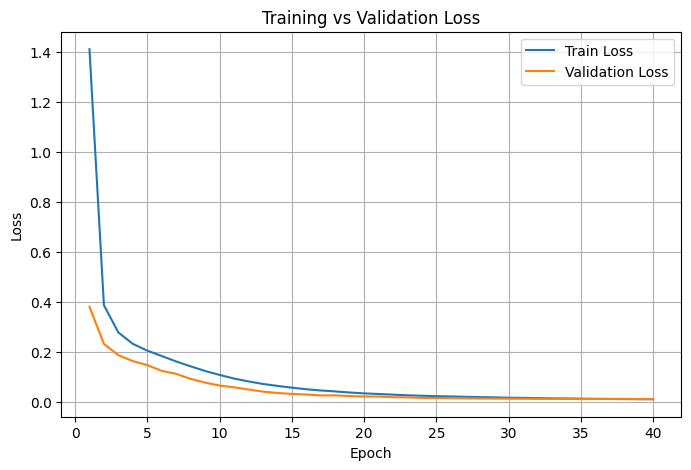

In [ ]:
# Dataset split
tdataset = YorubaDataset(df)
train_size = int(0.8 * len(tdataset))
val_size = len(tdataset) - train_size
train_dataset, val_dataset = random_split(tdataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Training parameters
epochs = 25
train_losses = []
val_losses = []

# Early stopping params
best_val_loss = float("inf")
patience = 3
counter = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # Save best model checkpoint
        torch.save(model.state_dict(), "best_mt5_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break

# Plot loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = model.generate(input_ids, max_length=64)
        predictions = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
        targets = [tokenizer.decode(lbl, skip_special_tokens=True) for lbl in labels]
        for pred, tgt in zip(predictions, targets):
            if pred == tgt:
                correct += 1
            total += 1
accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8734


In [ ]:
model.save_pretrained("yoruba_t5_finetuned")
tokenizer.save_pretrained("yoruba_t5_finetuned")


('yoruba_t5_finetuned/tokenizer_config.json',
 'yoruba_t5_finetuned/special_tokens_map.json',
 'yoruba_t5_finetuned/spiece.model',
 'yoruba_t5_finetuned/added_tokens.json')

In [ ]:
def predict(text):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).input_ids.to(device)
    outputs = model.generate(input_ids, max_length=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
test_inputs = [
    "I",
    "X",
    "XXX",
    "V̅CMXCIX",
    "V̅M"
]

for input_text in test_inputs:
    prediction = predict(input_text)
    print(f"Input: {input_text}, Predicted: {prediction}")

Input: I, Predicted: Okan
Input: X, Predicted: Eewa
Input: XXX, Predicted: Ogbon
Input: V̅CMXCIX, Predicted: dgbata ati Msanlelaadrun ladégbrun
Input: V̅M, Predicted: gbata


In [ ]:
!zip -r yoruba_mt5_finetuned.zip yoruba_t5_finetuned
from google.colab import files
files.download("yoruba_t5_finetuned")


updating: yoruba_t5_finetuned/ (stored 0%)
updating: yoruba_t5_finetuned/model.safetensors (deflated 8%)
updating: yoruba_t5_finetuned/spiece.model (deflated 48%)
updating: yoruba_t5_finetuned/generation_config.json (deflated 29%)
updating: yoruba_t5_finetuned/added_tokens.json (deflated 83%)
updating: yoruba_t5_finetuned/tokenizer_config.json (deflated 94%)
updating: yoruba_t5_finetuned/config.json (deflated 63%)
updating: yoruba_t5_finetuned/special_tokens_map.json (deflated 85%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

shutil.make_archive("yoruba_t5_finetuned", 'zip', "yoruba_t5_finetuned")


'/content/yoruba_t5_finetuned.zip'

In [ ]:
from google.colab import files

files.download("yoruba_t5_finetuned.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(val_dataset[0])


{'input_ids': tensor([3190,  434, 7589,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor([  411,   354,    23, 26532,    52,    77,   210,    32,     3,    32,
          109,   526,   210,     9,     9,    44,    23,     3,   935,    77,
            1,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

In [ ]:
import evaluate
from tqdm import tqdm

bleu = evaluate.load("bleu")

predictions = []
references = []

exact_matches = 0
total = 0

for example in tqdm(val_dataset):
    input_ids = example["input_ids"].unsqueeze(0).to(model.device)
    label_ids = example["labels"]

    reference = tokenizer.decode(label_ids, skip_special_tokens=True)
    generated_ids = model.generate(input_ids)
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    predictions.append(prediction)             # Full string
    references.append([reference])             # List of one reference string

    if prediction.strip() == reference.strip():
        exact_matches += 1
    total += 1

bleu_score = bleu.compute(predictions=predictions, references=references)
accuracy = exact_matches / total

print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"Exact Match Accuracy: {accuracy:.4f}")


100%|██████████| 1201/1201 [03:41<00:00,  5.42it/s]


BLEU Score: 0.7071
Exact Match Accuracy: 0.5770


In [ ]:
import evaluate
from tqdm import tqdm

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")


In [ ]:
import evaluate
from tqdm import tqdm

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

predictions = []
references = []

exact_matches = 0
total = 0

for example in tqdm(val_dataset):
    input_ids = example["input_ids"].unsqueeze(0).to(model.device)
    label_ids = example["labels"]

    reference = tokenizer.decode(label_ids, skip_special_tokens=True)
    generated_ids = model.generate(input_ids)
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    predictions.append(prediction)
    references.append([reference])

    if prediction.strip() == reference.strip():
        exact_matches += 1
    total += 1

# Compute BLEU
bleu_score = bleu.compute(predictions=predictions, references=references)

# For ROUGE, use non-nested list of strings
rouge_score = rouge.compute(predictions=predictions, references=[ref[0] for ref in references])

# Compute exact match accuracy
accuracy = exact_matches / total

# Display
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"Exact Match Accuracy: {accuracy:.4f}")
print("\nROUGE Scores:")
for key, value in rouge_score.items():
    print(f"  {key}: {value:.4f}")


100%|██████████| 1201/1201 [03:49<00:00,  5.23it/s]


BLEU Score: 0.7071
Exact Match Accuracy: 0.5770

ROUGE Scores:
  rouge1: 0.8552
  rouge2: 0.7941
  rougeL: 0.8549
  rougeLsum: 0.8550


In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c720fda58e014e402f4117b6799c6d2da1f07c606b133497e9339a1d1103f668
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import csv
from tqdm import tqdm

mismatches = []

for example in tqdm(val_dataset):
    input_ids = example["input_ids"].unsqueeze(0).to(model.device)
    label_ids = example["labels"]

    reference = tokenizer.decode(label_ids, skip_special_tokens=True).strip()
    generated_ids = model.generate(input_ids)
    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()

    if prediction != reference:
        mismatches.append({
            "Reference": reference,
            "Prediction": prediction
        })

print(f"Total mismatches logged: {len(mismatches)}")

# Save mismatches to CSV
csv_file = "translation_mismatches.csv"
with open(csv_file, mode="w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["Reference", "Prediction"])
    writer.writeheader()
    writer.writerows(mismatches)

print(f"Mismatches saved to {csv_file}")


100%|██████████| 1201/1201 [03:42<00:00,  5.40it/s]

Total mismatches logged: 508
Mismatches saved to translation_mismatches.csv


In [ ]:
%cd /content/


/content


In [ ]:
import os
print("Current directory:", os.getcwd())
print("Files in current directory:", os.listdir("."))


Current directory: /content
Files in current directory: ['.config', 'Yorubanumbers1-6000.csv', 'yoruba_t5_finetuned.zip', 'translation_mismatches.csv', 'yoruba_mt5_finetuned.zip', 'yoruba_t5_finetuned', 'sample_data']
